<a href="https://colab.research.google.com/github/Armelle-h/ML_frames_and_videos/blob/main/CosineSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CosineSimilarity.ipynb
In this notebook, we create some `Pair_Frames` data objects, use it to obtain CLIP preprocessed feature, and use the cosine similarity to obtain a score for classification.
## Imports:

In [ ]:
from google.colab import drive #allows you to have access to google drive from google colab
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_project_frames_and_videos') #For other uses, replace with the path of the working folder

import random
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
! pip install ftfy
! pip install torchmetrics
import torchmetrics
from tqdm import tqdm # to display loading bars

from Pair_Frames import Pair_Frames

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create train data with `Pair_Frames`:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select the device to use
video_dir='/content/drive/MyDrive/ML_project_frames_and_videos/DATA/videos' # the video directory
train_data = Pair_Frames(video_dir, train=0, device=device) # create the train data object
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,pin_memory=False) # create the iterable dataloader

## Iterate through the train data and get cosine similarity:

In [ ]:
labels = []
scores = []
cos = torch.nn.CosineSimilarity() # the cosimilarity function

maxiter = 7000

for i, (feature1, feature2, label) in enumerate(tqdm(train_dataloader,total=maxiter)):
    if i >= maxiter:
        break
    feature1 = feature1.cpu().float()
    feature2 = feature2.cpu().float()
    label = label.cpu()

    scores.append(cos(feature1, feature2).item())
    labels.append(label.item())

labels = torch.tensor(labels)
scores = torch.tensor(scores)

100%|██████████| 10000/10000 [1:52:55<00:00,  1.48it/s]


# Compute the best accuracy threshold and display the results:

The optimal accuracy is obtained at threshold = 0.6845194697380066 with accuracy = 0.8927000164985657


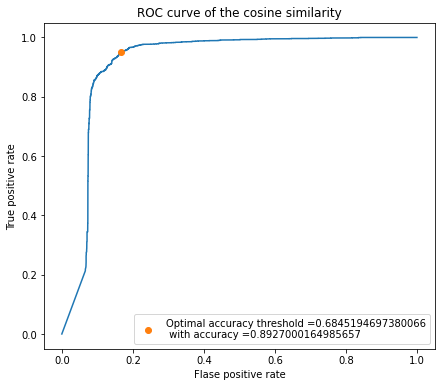

In [ ]:
roc = torchmetrics.classification.BinaryROC(thresholds=None) # roc curve computation function
# false positive rates and true positive rates of selected thresholds:
fpr, tpr, thresholds = roc(scores, labels)
accu = torchmetrics.functional.classification.binary_accuracy
accuracies = [accu(scores, labels, float(threshold)) for threshold in thresholds]
# compute best accuracy:
index_max = np.argmax(accuracies)
threshold = float(thresholds[index_max])
accuracy = float(accuracies[index_max])
# displays:
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("Flase positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr[index_max], tpr[index_max],'o',label="Optimal accuracy threshold ="+str(threshold)+ "\n with accuracy ="+str(accuracy))
plt.legend()
plt.title("ROC curve of the cosine similarity")
# plt.savefig("/content/drive/MyDrive/ML_project_frames_and_videos/Graphics/CosineSimilarityROC.pdf") # un-comment to save
print("The optimal accuracy is obtained at threshold =", threshold, "with accuracy =", accuracy)

# Create test data with `Pair_Frames`:

In [ ]:
threshold = 0.6845194697380066 # the optimal threshold obtained in the last part
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select the device to use
video_dir='/content/drive/MyDrive/ML_project_frames_and_videos/DATA/videos' # the video directory
length = 1500
validation_data = Pair_Frames(video_dir, train=1, length=length, device=device) # create the train data object
validation_dataloader = DataLoader(validation_data, batch_size=1, shuffle=True,pin_memory=False) # create the iterable dataloader

## Iterate through the test data, get cosine similarity, and predict the label according to the threshold:

In [ ]:
cos = torch.nn.CosineSimilarity() # the cosimilarity function
labels = []
predictions = []

for i, (feature1, feature2, label) in enumerate(tqdm(validation_dataloader)):
    feature1 = feature1.cpu().float()
    feature2 = feature2.cpu().float()
    labels.append(label.cpu())
    predictions.append(int(threshold < cos(feature1, feature2).item()))

labels = torch.tensor(labels)
predictions = torch.tensor(predictions)

## Compute the accurcy and some metrics, display the results:

In [ ]:
# computation of the numbers of True/False Positives/Negatives :
tp, fp, tn, fn, _ = torchmetrics.functional.classification.binary_stat_scores(predictions, labels)
# use them to compute accuracy and F1 score:
accuracy = (tp+tn) /length
F1_score = 2*tp / (2*tp + fp + fn)
print("On the validation set:")
print("true positive =", tp.item(), ", false positive =", fp.item())
print("true negative =", tn.item(), ", false negative =",fn.item())
print("accuracy =", accuracy.item(), ", F1 score =", F1_score.item())

On the validation set:
true positive = 608 , false positive = 7
true negative = 711 , false negative = 174
accuracy = 0.8793333172798157 , F1 score = 0.8704366683959961
